# Protein Data Bank (PDB)
# 蛋白质数据获取：蛋白质数据银行（PDB）


### 内容在理论中 ¶

-  蛋白质数据银行（PDB）
- 查询 PDB 使用 Python 包 `biotite` 和 `pypdb`

###  内容在实用篇中

-  选择一个查询蛋白
- 获取查询蛋白的 PDB 条目数量
- 查找满足特定条件的 PDB 条目
- 选择分辨率最高的 PDB 条目
- 获取顶级结构中配体的元数据
- 绘制顶配体分子
- 创建蛋白质-配体 ID 对
- 对齐 PDB 结构并提取配体

###  参考文献

- 蛋白质数据银行（PDB 网站）
- `pypdb` Python 软件包（生物信息学（2016），1，159-60；文档）
- `biotite` Python 软件包（BMC 生物信息学（2018），19；文档）
- 分子叠加与 Python 包 `opencadd` （仓库）

##  理论 ¶

### 蛋白质数据银行（PDB）

RCSB 蛋白质数据银行（PDB）是一个全面的生物信息学数据库，是结构生物学领域，如结构基因组学和药物设计等关键资源（PDB 网站）。

结构数据来源于结构确定方法，如 X 射线晶体学（最常见方法）、核磁共振（NMR）和冷冻电子显微镜（cryo-EM）。对于每个条目，数据库包含（i）蛋白质、配体、辅因子、水分子和离子的原子 3D 坐标以及连接这些原子的键，以及（ii）关于结构数据的元信息，如 PDB ID、作者、沉积日期、使用的结构确定方法和结构分辨率。结构分辨率是收集数据质量的度量，单位为Å（埃）；值越低，结构质量越高。

### 查询 PDB 使用 Python 包 `biotite` 和 `pypdb` ¶

query one ( `FieldQuery` ，见文档) 或更多 ( `CompositeQuery` ，见文档) 的这些字段以检索符合我们标准的 PDB ID 的数量 ( `count` ) 或列表 ( `search` )。

In [5]:
import collections
import logging
import pathlib
import time
import warnings
import datetime

import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from tqdm.auto import tqdm
import redo
import requests_cache
import nglview
import pypdb
import biotite.database.rcsb as rcsb
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools

from opencadd.structure.superposition.api import align, METHODS
from opencadd.structure.core import Structure

# Disable some unneeded warnings
logger = logging.getLogger("opencadd")
logger.setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

# Cache requests -- this will speed up repeated queries to PDB
requests_cache.install_cache("rcsb_pdb", backend="memory")

In [6]:
from pathlib import Path
import os

# 获取当前工作目录
HERE = Path(os.getcwd())
DATA = HERE / 'data'
if not DATA.exists():
    DATA.mkdir(parents=True, exist_ok=True)
print(DATA)


/Users/wangyang/Desktop/Breast_cancer_brain_metastasis/wang_Gene/AIDD/13_Protein_data_acquisition-Protein_Data_Bank_(PDB)/data


### 选择查询蛋白 ¶

我们使用 AURKA 作为本演讲的查询蛋白。 AURKA 的 UniProt ID 为 `O14965` ，下面将使用该 ID 来查询 PDB 数据库。

In [7]:
uniprot_id = "O14965"

### 获取查询蛋白质的 PDB 条目数 ¶

AURKA 的 PDB 中有多少可用结构（在本笔记本上次运行时）？

In [10]:
query_by_uniprot_id = rcsb.FieldQuery(
    "rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession",
    exact_match=uniprot_id,
)
today = datetime.datetime.now()
print(
    f"结构数 {today.year}-{today.month}-{today.day}: {rcsb.count(query_by_uniprot_id)}"
)

结构数 2024-10-10: 186


自 1971 年 PDB 成立以来，每年有多少个可用结构？

In [11]:
# 确定年份清单和特定年份的可用结构数量
years = range(1971, datetime.datetime.now().year)
n_structures = []

for year in years:
    # 设定允许沉积的最晚日期
    before_deposition_date = f"{year}-12-31T23:59:59Z"
    # 对最近给定日期存放的结构建立查询
    query_by_deposition_date = rcsb.FieldQuery(
        "rcsb_accession_info.deposit_date", less_or_equal=before_deposition_date
    )
    # 建立组合查询
    query = rcsb.CompositeQuery(
        [query_by_uniprot_id, query_by_deposition_date],
        "and",
    )
    # 统计匹配结构并添加到列表中
    n_structures.append(rcsb.count(query))
    # 稍候，以免 API 超载
    time.sleep(0.1)

绘制结果！

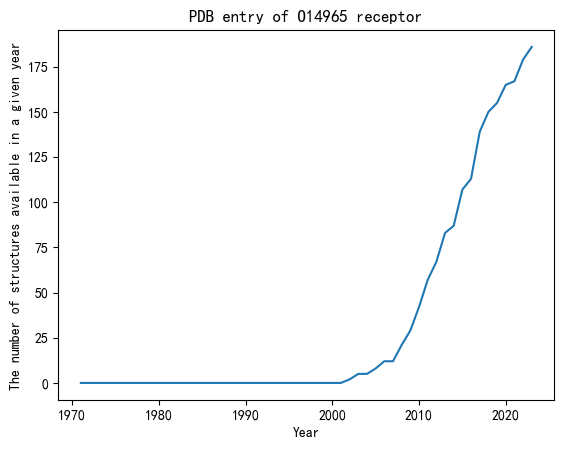

In [12]:
# 防止中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.plot(years, n_structures)
plt.title("PDB entry of O14965 receptor")
plt.xlabel("Year")
plt.ylabel("The number of structures available in a given year");

### 查找满足某些条件的 PDB 条目 ¶

我们将搜索描述 PDB 中满足以下条件的结构的 PDB ID：

- UniProt ID O14965 的结构：这是我们感兴趣的目标，AURKA！
- 2024 年之前沉积的结构：此步骤用于内部维护目的。我们只会考虑 2024 年之前沉积的结构。这样，随着时间的推移，该笔记本的结果将保持不变，从而使我们能够通过持续集成 (CI) 检查该笔记本是否不会停止服务。
- 通过 X 射线晶体学解析结构：我们可以包括所有方法，但让我们查看 API 以了解如何选择实验方法。
- 结构的分辨率小于或等于3.0：分辨率值越低，结构的质量越高，即指定的原子3D坐标正确的确定性。可以确定低于 3 Å 的原子取向。因此，该阈值通常用于与基于结构的药物设计相关的结构。
- 结构只有一条链：我们这样做是为了让以后的生活更轻松。
- 结构中有分子量大于100.0 Da的配体：PDB注释的配体可以是配体，也可以是溶剂和离子。为了仅过滤配体结合的结构，我们仅保留具有至少 100.0 Da 的注释配体的结构（许多溶剂和离子重量更轻）。注意：这是简单但不全面的溶剂和离子排除。

我们再次使用 `biotite` 包根据以下组合查询来查询 PDB ID：

我们定义我们的标准。

In [13]:
uniprot_id = "O14965"
before_deposition_date = "2024-06-01T00:00:00Z"
experimental_method = "X-RAY DIFFRACTION"
max_resolution = 3.0
n_chains = 1
min_ligand_molecular_weight = 100.0

我们设置每个查询。

In [14]:
query_by_uniprot_id = rcsb.FieldQuery(
    "rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession",
    exact_match=uniprot_id,
)
query_by_deposition_date = rcsb.FieldQuery(
    "rcsb_accession_info.deposit_date", less=before_deposition_date
)
query_by_experimental_method = rcsb.FieldQuery("exptl.method", exact_match=experimental_method)
query_by_resolution = rcsb.FieldQuery(
    "rcsb_entry_info.resolution_combined", less_or_equal=max_resolution
)
query_by_polymer_count = rcsb.FieldQuery(
    "rcsb_entry_info.deposited_polymer_entity_instance_count", equals=n_chains
)
query_by_ligand_mw = rcsb.FieldQuery(
    "chem_comp.formula_weight", molecular_definition=True, greater=min_ligand_molecular_weight
)

我们单独执行每个查询并检查每个条件的匹配数。

In [15]:
print(f"具有Uniprot蛋白数据库身份标识号的结构数量 {uniprot_id}: {rcsb.count(query_by_uniprot_id)}")
time.sleep(0.1)  # wait shortly to not overload the API
print(
    f"之前沉积的结构数量 {before_deposition_date}: {rcsb.count(query_by_deposition_date)}"
)
time.sleep(0.1)
print(
    f"分解的结构数 {experimental_method}: {rcsb.count(query_by_experimental_method)}"
)
time.sleep(0.1)
print(
    f"分辨率小于或等于的结构数 {max_resolution}: {rcsb.count(query_by_resolution)}"
)
time.sleep(0.1)
print(f"仅有的结构数量 {n_chains} chain: {rcsb.count(query_by_polymer_count)}")
time.sleep(0.1)
print(
    f"配体大于或等于的结构数目 {min_ligand_molecular_weight} Da: {rcsb.count(query_by_ligand_mw)}"
)

具有Uniprot蛋白数据库身份标识号的结构数量 O14965: 186
之前沉积的结构数量 2024-06-01T00:00:00Z: 225387
分解的结构数 X-RAY DIFFRACTION: 188438
分辨率小于或等于的结构数 3.0: 182729
仅有的结构数量 1 chain: 79981
配体大于或等于的结构数目 100.0 Da: 225945


我们将所有查询与 and 运算符结合起来，以仅匹配满足所有条件的 PDB ID。

In [16]:
query = rcsb.CompositeQuery(
    [
        query_by_uniprot_id,
        query_by_deposition_date,
        query_by_experimental_method,
        query_by_resolution,
        query_by_polymer_count,
        query_by_ligand_mw,
    ],
    "and",
)
pdb_ids = rcsb.search(query)
print(f"匹配数量s: {len(pdb_ids)}")
print("选择了Pdb IDS:")
print(*pdb_ids)

匹配数量s: 132
选择了Pdb IDS:
1MQ4 1MUO 1OL6 1OL7 2C6D 2DWB 2NP8 2W1D 2W1E 2W1F 2W1G 2WQE 2X6D 2X81 2XNE 2XNG 2XRU 3FDN 3H0Y 3K5U 3LAU 3M11 3MYG 3P9J 3R21 3R22 3UO4 3UO5 3UOD 3UP2 3VAP 3W10 3W16 4B0G 4BN1 4BYI 4BYJ 4C3R 4CEG 4DEA 4DEE 4J8M 4JAJ 4JBO 4JBP 4JBQ 4O0S 4O0U 4O0W 4PRJ 4UYN 4UZH 4ZS0 4ZTQ 4ZTR 4ZTS 5AAF 5AAG 5DN3 5DNR 5DOS 5DPV 5DR2 5DR6 5DR9 5DRD 5DT0 5DT3 5DT4 5EW9 5OBJ 5OBR 5ONE 5ORL 5ORN 5ORO 5ORP 5ORR 5ORS 5ORT 5ORV 5ORW 5ORX 5ORY 5ORZ 5OS0 5OS1 5OS2 5OS3 5OS4 5OS5 5OS6 5OSD 5OSE 5OSF 5ZAN 6C2R 6C2T 6CPE 6CPF 6GRA 6HJJ 6HJK 6I2U 6R49 6R4A 6R4B 6R4C 6R4D 6VPG 6VPH 6VPI 6VPJ 6XKA 6Z4Y 7AYH 7AYI 7FIC 8C14 8C15 8C1D 8C1E 8C1F 8C1G 8C1H 8C1I 8C1K 8C1M 8JF4 8JG8 8JMX 8OF5


### 选择最高分辨率的 PDB 条目 ¶

到目前为止，我们已经使用某些搜索条件来查找感兴趣的 PDB 条目。

目前，我们无法直接通过 `biotite` 访问结构体的分辨率；使用 `biotite` 我们只能检查分辨率是否满足特定条件。相反，我们下载所选 PDB ID 的完整元数据。为此，我们使用 `pypdb` 包中的方法 `describe_pdb` 。每个结构的元数据都作为字典返回。

注意：我们在这里只获取 PDB 结构的元信息，我们还没有获取结构（3D 坐标）。

redo.retriable 行是一个装饰器。这包装了该函数并提供了额外的功能。在这种情况下，它将自动重试失败的查询（最多 10 次）。

In [17]:
@redo.retriable(attempts=10, sleeptime=2)
def describe_one_pdb_id(pdb_id):
    """Fetch meta information from PDB."""
    described = pypdb.describe_pdb(pdb_id)
    if described is None:
        print(f"! Error while fetching {pdb_id}, retrying ...")
        raise ValueError(f"Could not fetch PDB id {pdb_id}")
    return described

In [18]:
pdbs_data = [describe_one_pdb_id(pdb_id) for pdb_id in tqdm(pdb_ids)]

  0%|          | 0/132 [00:00<?, ?it/s]

让我们看一下第一个 PDB ID 的元数据（键只是因为字典包含很多信息，我们不想在这里打印）。在 PDB 结构和 PDBx/mmCIF 格式初学者指南中查找有关 PDB 元数据的更多信息。

In [19]:
print("\n".join(pdbs_data[0].keys()))

audit_author
cell
citation
diffrn
diffrn_detector
diffrn_radiation
diffrn_source
entry
exptl
exptl_crystal
exptl_crystal_grow
pdbx_audit_revision_category
pdbx_audit_revision_details
pdbx_audit_revision_group
pdbx_audit_revision_history
pdbx_audit_revision_item
pdbx_database_related
pdbx_database_status
pdbx_initial_refinement_model
rcsb_accession_info
rcsb_entry_container_identifiers
rcsb_entry_info
rcsb_primary_citation
refine
refine_analyze
refine_hist
refine_ls_restr
reflns
reflns_shell
software
struct
struct_keywords
symmetry
rcsb_id


让我们仔细看看我们感兴趣的两个键：包含 PDB ID ( "id" ) 的 "entry" 键和包含 PDB ID ( "id" ) 的 "rcsb_entry_info" 键。其中包含结构的分辨率 ( "resolution_combined" )。

In [20]:
pdbs_data[0]["entry"]

{'id': '1MQ4'}

In [21]:
pdbs_data[0]["rcsb_entry_info"]

{'assembly_count': 1,
 'branched_entity_count': 0,
 'cis_peptide_count': 0,
 'deposited_atom_count': 2211,
 'deposited_deuterated_water_count': 0,
 'deposited_hydrogen_atom_count': 0,
 'deposited_model_count': 1,
 'deposited_modeled_polymer_monomer_count': 261,
 'deposited_nonpolymer_entity_instance_count': 4,
 'deposited_polymer_entity_instance_count': 1,
 'deposited_polymer_monomer_count': 272,
 'deposited_solvent_atom_count': 72,
 'deposited_unmodeled_polymer_monomer_count': 11,
 'diffrn_radiation_wavelength_maximum': 1.0,
 'diffrn_radiation_wavelength_minimum': 1.0,
 'disulfide_bond_count': 0,
 'entity_count': 5,
 'experimental_method': 'X-ray',
 'experimental_method_count': 1,
 'inter_mol_covalent_bond_count': 0,
 'inter_mol_metalic_bond_count': 13,
 'molecular_weight': 32.01,
 'na_polymer_entity_types': 'Other',
 'nonpolymer_bound_components': ['ADP', 'MG'],
 'nonpolymer_entity_count': 3,
 'nonpolymer_molecular_weight_maximum': 0.43,
 'nonpolymer_molecular_weight_minimum': 0.02,


现在，我们将每个 PDB ID 的分辨率保存为 pandas DataFrame，按分辨率升序排序。

In [22]:
resolution = pd.DataFrame(
    [
        [pdb_data["entry"]["id"], pdb_data["rcsb_entry_info"]["resolution_combined"][0]]
        for pdb_data in pdbs_data
    ],
    columns=["pdb_id", "resolution"],
).sort_values(by="resolution", ignore_index=True)
resolution

,pdb_id,resolution
0,5ORL,1.690000
1,6C2T,1.730000
2,5OS0,1.740000
3,5OS5,1.740000
4,5OS3,1.810000
...,...,...
127,8JMX,2.950202
128,2W1D,2.970000
129,5DOS,2.980000
130,1OL6,3.000000


从顶层结构获取配体的元数据 ¶

In [23]:
top_num = 10 # 顶部结构数量

In [24]:
top_num

10

在下一节中，我们将以最高分辨率从顶部 top_num 结构构建基于配体的整体药效团

In [25]:
selected_pdb_ids = resolution[:top_num]["pdb_id"].to_list()
print(f"选定的 PDB ID: {selected_pdb_ids}")

选定的 PDB ID: ['5ORL', '6C2T', '5OS0', '5OS5', '5OS3', '4J8M', '5ORV', '5OS4', '5ORX', '5OSF']


选定的最高分辨率 PDB 条目可以包含针对不同结合位点的配体，例如变构和正构配体，这会阻碍基于配体的药效团的生成。因此，我们将重点关注以下 4 个结构，它们在正位结合口袋中含有配体。笔记本后面提供的代码可用于验证这一点。

In [26]:
import csv
from Bio import PDB

# 定义要处理的 PDB ID 列表
pdb_ids = selected_pdb_ids

# 创建一个 PDB Parser 对象
parser = PDB.PDBParser(QUIET=True)

# 定义函数来获取 PDB 文件
def fetch_pdb_file(pdb_id):
    pdb_list = PDB.PDBList()
    pdb_file = pdb_list.retrieve_pdb_file(pdb_id, pdir='.', file_format='pdb')
    return pdb_file

# 定义函数来提取配体信息
def get_ligand_info(pdb_id):
    pdb_file = fetch_pdb_file(pdb_id)
    structure = parser.get_structure(pdb_id, pdb_file)
    ligand_info = []

    for model in structure:
        for chain in model:
            for residue in chain:
                # 只提取异源物（配体）的信息
                if residue.id[0] != ' ':
                    ligand_info.append({
                        'pdb_id': pdb_id,
                        'chain_id': chain.id,
                        'residue_name': residue.resname,
                        'residue_id': residue.id
                    })

    return ligand_info

# 获取所有 PDB 条目的配体信息并计算 Residue ID 的数量
pdb_ligand_counts = []
for pdb_id in pdb_ids:
    ligand_info = get_ligand_info(pdb_id)
    pdb_ligand_counts.append({
        'pdb_id': pdb_id,
        'ligand_count': len(ligand_info)
    })
    print(f"PDB ID: {pdb_id}, 配体数量: {len(ligand_info)}")

# 根据配体数量从小到大排序
sorted_pdb_ligand_counts = sorted(pdb_ligand_counts, key=lambda x: x['ligand_count'])

# 打印排序后的结果
for entry in sorted_pdb_ligand_counts:
    print(f"PDB ID: {entry['pdb_id']}, 配体数量: {entry['ligand_count']}")

# 保存结果到 CSV 文件
csv_filename = DATA / 'pdb_ligand_counts.csv'
csv_headers = ['PDB ID', 'Ligand Count']

with open(csv_filename, mode='w', newline='') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=csv_headers)
    writer.writeheader()
    for entry in sorted_pdb_ligand_counts:
        writer.writerow({'PDB ID': entry['pdb_id'], 'Ligand Count': entry['ligand_count']})

print(f"结果已保存到 {csv_filename}")


Structure exists: './pdb5orl.ent' 
PDB ID: 5ORL, 配体数量: 205
Structure exists: './pdb6c2t.ent' 
PDB ID: 6C2T, 配体数量: 114
Structure exists: './pdb5os0.ent' 
PDB ID: 5OS0, 配体数量: 146
Structure exists: './pdb5os5.ent' 
PDB ID: 5OS5, 配体数量: 133
Structure exists: './pdb5os3.ent' 
PDB ID: 5OS3, 配体数量: 155
Structure exists: './pdb4j8m.ent' 
PDB ID: 4J8M, 配体数量: 179
Structure exists: './pdb5orv.ent' 
PDB ID: 5ORV, 配体数量: 105
Structure exists: './pdb5os4.ent' 
PDB ID: 5OS4, 配体数量: 144
Structure exists: './pdb5orx.ent' 
PDB ID: 5ORX, 配体数量: 122
Structure exists: './pdb5osf.ent' 
PDB ID: 5OSF, 配体数量: 89
PDB ID: 5OSF, 配体数量: 89
PDB ID: 5ORV, 配体数量: 105
PDB ID: 6C2T, 配体数量: 114
PDB ID: 5ORX, 配体数量: 122
PDB ID: 5OS5, 配体数量: 133
PDB ID: 5OS4, 配体数量: 144
PDB ID: 5OS0, 配体数量: 146
PDB ID: 5OS3, 配体数量: 155
PDB ID: 4J8M, 配体数量: 179
PDB ID: 5ORL, 配体数量: 205
结果已保存到 /Users/wangyang/Desktop/Breast_cancer_brain_metastasis/wang_Gene/AIDD/13_Protein_data_acquisition-Protein_Data_Bank_(PDB)/data/pdb_ligand_counts.csv


In [27]:
# 获取pdb_ids前面10个
pdb_ids = pdb_ids[:10]
pdb_ids

['5ORL',
 '6C2T',
 '5OS0',
 '5OS5',
 '5OS3',
 '4J8M',
 '5ORV',
 '5OS4',
 '5ORX',
 '5OSF']

In [59]:
selected_pdb_ids = ['6C2T']   # ['5ORL', '5OS0', '5OS5', '5OS3', '5ORX', '5OSF']
print(f"Selected PDB IDs (frozen set): {selected_pdb_ids}")

Selected PDB IDs (frozen set): ['6C2T']


们使用 get_ligands 获取有关顶级 top_num 配体的 PDB 信息，并将其存储为 csv 文件（作为每个配体的字典）。

如果一个结构包含多个配体，我们选择最大的配体。注意：这是在蛋白质结合位点选择配体的简单但不全面的方法。该方法还可以选择与蛋白质结合的辅因子。因此，在进一步使用之前，请目视检查自动选择的顶级配体。

In [60]:
def get_ligands(pdb_id):
    """
    RCSB 尚未提供配体信息的新终点。作为
    我们从 ligand-expo.rcsb.org 获取额外信息、
    获取额外信息。有关此技术的更多信息，请查阅 T011！
    """
    pdb_info = _fetch_pdb_nonpolymer_info(pdb_id)
    ligand_expo_ids = [
        nonpolymer_entities["pdbx_entity_nonpoly"]["comp_id"]
        for nonpolymer_entities in pdb_info["data"]["entry"]["nonpolymer_entities"]
    ]

    ligands = {}
    for ligand_expo_id in ligand_expo_ids:
        ligand_expo_info = _fetch_ligand_expo_info(ligand_expo_id)
        ligands[ligand_expo_id] = ligand_expo_info

    return ligands


def _fetch_pdb_nonpolymer_info(pdb_id):
    """
    从 rcsb.org 获取非聚合物数据。
    感谢 @BJWiley233 和 Rachel Green 提供此 GraphQL 解决方案。
    """
    query = (
        """{
          entry(entry_id: "%s") {
            nonpolymer_entities {
              pdbx_entity_nonpoly {
                comp_id
                name
                rcsb_prd_id
              }
            }
          }
        }"""
        % pdb_id
    )

    query_url = f"https://data.rcsb.org/graphql?query={query}"
    response = requests.get(query_url)
    response.raise_for_status()
    info = response.json()
    return info


def _fetch_ligand_expo_info(ligand_expo_id):
    """
    Fetch ligand data from ligand-expo.rcsb.org.
    """
    r = requests.get(f"http://ligand-expo.rcsb.org/reports/{ligand_expo_id[0]}/{ligand_expo_id}/")
    r.raise_for_status()
    html = BeautifulSoup(r.text)
    info = {}
    for table in html.find_all("table"):
        for row in table.find_all("tr"):
            cells = row.find_all("td")
            if len(cells) != 2:
                continue
            key, value = cells
            if key.string and key.string.strip():
                info[key.string.strip()] = "".join(value.find_all(string=True))

    # Postprocess some known values
    info["Molecular weight"] = float(info["Molecular weight"].split()[0])
    info["Formal charge"] = int(info["Formal charge"])
    info["Atom count"] = int(info["Atom count"])
    info["Chiral atom count"] = int(info["Chiral atom count"])
    info["Bond count"] = int(info["Bond count"])
    info["Aromatic bond count"] = int(info["Aromatic bond count"])
    return info

In [61]:
columns = [
    "@structureId",
    "@chemicalID",
    "@type",
    "@molecularWeight",
    "chemicalName",
    "formula",
    "InChI",
    "InChIKey",
    "smiles",
]
rows = []
for pdb_id in selected_pdb_ids:
    ligands = get_ligands(pdb_id)
    # 如果包含多个配体，则取最大配体（结果中的第一位）
    ligand_id, properties = max(ligands.items(), key=lambda kv: kv[1]["Molecular weight"])
    rows.append(
        [
            pdb_id,
            ligand_id,
            properties["Component type"],
            properties["Molecular weight"],
            properties["Name"],
            properties["Formula"],
            properties["InChI descriptor"],
            properties["InChIKey descriptor"],
            properties["Stereo SMILES (OpenEye)"],
        ]
    )

In [62]:

# 格式改为DataFrame
ligands = pd.DataFrame(rows, columns=columns)
ligands

,@structureId,@chemicalID,@type,@molecularWeight,chemicalName,formula,InChI,InChIKey,smiles
0,6C2T,EGJ,NON-POLYMER,525.037,"(2S,4R)-1-[(3-chloro-2-fluorophenyl)methyl]-2-...",C27 H26 Cl F N4 O2 S,"InChI=1S/C27H26ClFN4O2S/c1-17-14-27(25(34)35,9...",GKVNGMCPNCGMBE-CBZJRKILSA-N,C[C@H]1C[C@](CCN1Cc2cccc(c2F)Cl)(Cc3c4ccccc4cc...


In [63]:
ligands.to_csv(DATA / "selected_ligands.csv", index=False)
print(f"结果已保存到 {DATA / 'selected_ligands.csv'}")

结果已保存到 /Users/wangyang/Desktop/Breast_cancer_brain_metastasis/wang_Gene/AIDD/13_Protein_data_acquisition-Protein_Data_Bank_(PDB)/data/selected_ligands.csv


In [64]:
ligands.to_csv(DATA / "PDB_top_ligands.csv", header=True, index=False)

绘制顶部配体分子

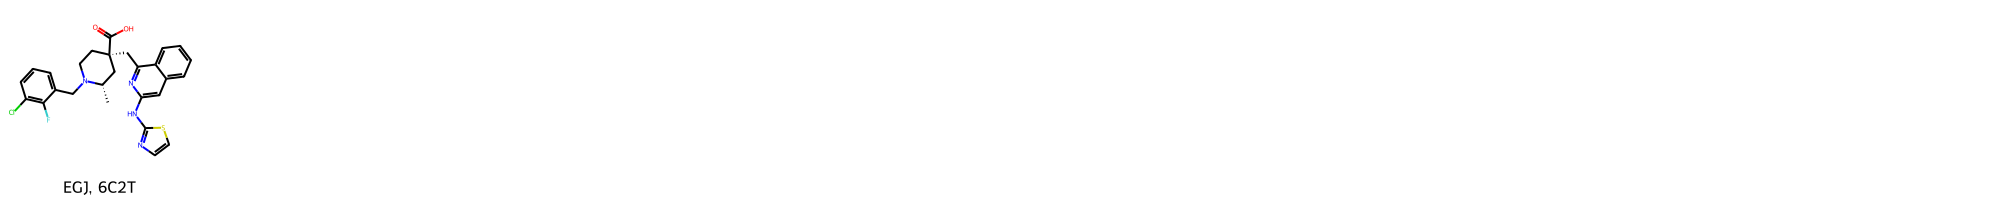

In [65]:
PandasTools.AddMoleculeColumnToFrame(ligands, "smiles")
Draw.MolsToGridImage(
    mols=list(ligands.ROMol),
    legends=list(ligands["@chemicalID"] + ", " + ligands["@structureId"]),
    molsPerRow=top_num,
)

创建蛋白质-配体 ID 对 ¶

In [66]:

pairs = collections.OrderedDict(zip(ligands["@structureId"], ligands["@chemicalID"]))
pairs

OrderedDict([('6C2T', 'EGJ')])

### 对齐 PDB 结构并提取配体 ¶

由于我们希望在下一篇演讲中构建基于配体的整体药效团，因此有必要在 3D 中将所有结构相互对齐。

我们将使用Python包 `opencadd` （存储库），其中包括一个3D叠加子包来指导蛋白质的结构对齐。该方法基于由所提供的匹配残基的序列比对引导的叠加。包中还有其他方法，但这个简单的方法足以完成手头的任务。

#### 获取 PDB 结构文件 ¶

现在，我们使用 `opencadd.structure.superposition` 从 PDB 中获取 PDB 结构文件，即蛋白质、配体（以及其他可用的原子或分子实体，如辅因子、水分子和离子）的 3D 坐标。

可用的文件格式为 pdb 和 cif，它们存储蛋白质原子（以及配体、辅因子、水分子和离子）的 3D 坐标以及原子间键的信息。在这里，我们使用 pdb 文件。

In [67]:
import MDAnalysis as mda
from MDAnalysis.core.universe import Universe
from io import StringIO
import requests
from collections import OrderedDict

# 定义函数来下载 PDB 结构
def download_pdb_structure(pdb_id):
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    try:
        response = requests.get(url, verify=False)
        if response.status_code == 200:
            return response.text
        else:
            print(f"Failed to download {pdb_id}. Status code: {response.status_code}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Error occurred while downloading {pdb_id}: {e}")
        return None

# 定义结构和配体信息


# 下载结构文件
structures = {pdb_id: download_pdb_structure(pdb_id) for pdb_id in pairs}

# 使用 MDAnalysis 解析每个结构并选择配体和蛋白质
complexes = []

for pdb_id, pdb_content in structures.items():
    if pdb_content:
        # 将 PDB 文件内容加载到 MDAnalysis
        u = mda.Universe(StringIO(pdb_content), format='pdb')
        ligand = pairs[pdb_id]

        # 选择蛋白质或指定的配体
        selected_atoms = u.select_atoms(f"protein or resname {ligand}")

        # 创建包含蛋白质和配体的复合物
        complexes.append(selected_atoms)

# 打印每个复合物的信息
for i, complex in enumerate(complexes):
    print(f"Complex {i + 1}: {complex}")


Complex 1: <AtomGroup [<Atom 1: N of type N of resname TRP, resid 128 and segid A and altLoc >, <Atom 2: CA of type C of resname TRP, resid 128 and segid A and altLoc >, <Atom 3: C of type C of resname TRP, resid 128 and segid A and altLoc >, ..., <Atom 2117: H59 of type H of resname EGJ, resid 401 and segid A and altLoc >, <Atom 2118: H61 of type H of resname EGJ, resid 401 and segid A and altLoc >, <Atom 2119: H62 of type H of resname EGJ, resid 401 and segid A and altLoc >]>


#### 提取蛋白质和配体 ¶

从结构中提取蛋白质和配体，以去除溶剂和晶体学的其他伪影。

In [68]:

complexes

[<AtomGroup with 2119 atoms>]

In [69]:
# Write complex to file
for complex_, pdb_id in zip(complexes, pairs.keys()):
    complex_.write(DATA / f"{pdb_id}.pdb")

#### 对齐蛋白质 ¶

对齐复合物（基于蛋白质原子）。

nglview 可用于可视化 Jupyter 笔记本中的分子数据。在下一个细胞中，我们将可视化对齐的蛋白质-配体复合物。

In [70]:
view = nglview.NGLWidget()
for complex_ in complexes:
    view.add_component(complex_.atoms)
view

NGLWidget()

In [71]:
view.render_image(trim=True, factor=2, transparent=True);

In [72]:
view._display_image()

 提取配体 ¶

In [73]:
ligands = [
    Structure.from_atomgroup(complex_.select_atoms(f"resname {ligand}"))
    for complex_, ligand in zip(complexes, pairs.values())
]
ligands

[<Universe with 62 atoms>]

In [74]:
for ligand, pdb_id in zip(ligands, pairs.keys()):
    ligand.write(DATA / f"{pdb_id}_lig.pdb")

我们检查所有配体 pdb 文件是否存在。

In [75]:
ligand_files = []
for file in DATA.glob("*_lig.pdb"):
    ligand_files.append(file.name)
ligand_files

['5ORX_lig.pdb',
 '5OS4_lig.pdb',
 '5OS5_lig.pdb',
 '5ORL_lig.pdb',
 '5OSF_lig.pdb',
 '4J8M_lig.pdb',
 '6C2T_lig.pdb',
 '5ORV_lig.pdb',
 '5OS3_lig.pdb',
 '5OS0_lig.pdb']

我们还可以使用 nglview 来单独描述共结晶的配体。正如我们所看到的，所选复合物包含填充相同结合袋的配体，因此可以在下一个演讲中用于基于配体的药效团生成。

In [76]:
view = nglview.NGLWidget()
for component_id, ligand in enumerate(ligands):
    view.add_component(ligand.atoms)
    view.remove_ball_and_stick(component=component_id)
    view.add_licorice(component=component_id)
view

NGLWidget()

In [77]:
view.render_image(trim=True, factor=2, transparent=True);

In [78]:
view._display_image()